In [1]:
from pathlib import Path
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import matplotlib.colors as mcolors
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

def get_shades(color, n_shades=6):
    base_color = mcolors.to_rgba(color)
    return [mcolors.to_hex((base_color[0], base_color[1], base_color[2], base_color[3] * (i / n_shades))) for i in range(1, n_shades + 1)]

filepaths = OmegaConf.load("../configs/filepaths/base.yaml")
mlflow.set_tracking_uri(filepaths.tracking_uri)

Wrangle top model run ids

In [2]:
top_models = pd.read_csv(Path(filepaths.artifacts) / "250209_top_models.csv", sep=',')
top_cgr = pd.read_csv(Path(filepaths.artifacts) / "250223_top_cgr_models.csv", sep=',')
top_models = pd.concat((top_models, top_cgr), axis=0, ignore_index=True)
top_models.head()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,X_d_transform,batch_norm,...,epoch,train_loss,val/accuracy,val/binary_precision,val/binary_recall,val/f1,val/mcc,val/prc,val/roc,val_loss
0,2025-02-07 13:21:04,3.9h,ff90895a6070499b8fdcdc0982526885,dazzling-rat-180,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.025103,0.809866,0.963687,0.631624,0.762649,0.653961,0.921851,0.912527,0.762649
1,2025-02-07 13:20:39,3.1h,8a155bc5673b4c6aa8667dd55755fe0b,zealous-eel-839,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.002602,0.809679,0.972779,0.624411,0.760160,0.656536,0.959718,0.961152,0.760160
2,2025-02-07 13:20:39,3.1h,5ca6ba7b8aec4b81a366e9138b9c09b0,smiling-colt-432,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.004807,0.797277,0.969662,0.600536,0.741214,0.635536,0.947565,0.949833,0.741214
3,2025-02-07 13:20:35,3.4h,2241478505f9497885d25b9a0dee3ffd,fortunate-panda-724,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.027877,0.950560,0.979499,0.919235,0.948325,0.902712,0.986876,0.986808,0.948325
4,2025-02-07 13:20:33,3.4h,e638683b53f84d0ba1c8f32794413e0e,burly-goat-264,LOCAL,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,spn1560,FINISHED,NaN,True,...,24,0.044305,0.949125,0.977389,0.918329,0.946844,0.899774,0.984206,0.986065,0.946844


In [3]:
outer_run_ids = top_models['Run ID'].to_list()
print(",".join(outer_run_ids))

ff90895a6070499b8fdcdc0982526885,8a155bc5673b4c6aa8667dd55755fe0b,5ca6ba7b8aec4b81a366e9138b9c09b0,2241478505f9497885d25b9a0dee3ffd,e638683b53f84d0ba1c8f32794413e0e,fb3c7a9061a744fba7dabf9d50092414,4bf93c6830744a4b8e6d8076f14a82e1,ef2ce94281fb445ba304791f991e23cc,3c1ce655b064442cb7789fa210e4caaf,2a7b803f790143f0b14a1955117cb393


In [4]:
search_cols = [
    "data/neg_multiple",
    "data/split_strategy",
    "training/pos_multiplier",
    "model/name",
    "model/d_h_encoder",
    "model/encoder_depth",
    "model/radius",
    "model/vec_len",
]

top_models.loc[:, search_cols]

,data/neg_multiple,data/split_strategy,training/pos_multiplier,model/name,model/d_h_encoder,model/encoder_depth,model/radius,model/vec_len
0,3,rcmcs,3,bom,300,6.0,NaN,NaN
1,3,rcmcs,3,rc_agg,300,4.0,NaN,NaN
2,3,rcmcs,3,rc_cxn,300,6.0,NaN,NaN
3,3,homology,3,rc_cxn,300,6.0,NaN,NaN
4,3,homology,3,rc_agg,300,4.0,NaN,NaN
5,3,rcmcs,3,mfp,300,NaN,2.0,2048.0
6,3,homology,3,mfp,300,NaN,2.0,2048.0
7,3,homology,3,bom,300,6.0,NaN,NaN
8,3,homology,3,cgr,300,4.0,NaN,NaN
9,3,rcmcs,3,cgr,300,6.0,NaN,NaN


In [5]:
# Search for all inner folds corresponding to top models

split_runs = {}
for i, row in top_models.iterrows():
    conditions = [
        "params.'data/split_idx' != '-1'", # Not tested on outer fold
        "params.'data/split_idx' != '-2'", # Nor trained on full dataset
    ]
    for col in search_cols:
        val = row[col]

        if pd.isna(val):
            continue
        
        if isinstance(val, float) and val % 1 == 0:
            val = int(val)

        conditions.append(f"params.'{col}' = '{val}'")

    filter_string = " AND ".join(conditions)
    split_runs[row['Run ID']] = mlflow.search_runs(filter_string=filter_string)

In [6]:
# Search for bom and rc_agg tested on outer fold with all # of message passings

model_filter_string = ["params.'model/name' = 'bom'", " params.'model/name' = 'rc_agg'"]
split_filter_string = "params.'data/split_idx' = '-1'"
message_passing_sweep = []
for mfs in model_filter_string:
    filter_string = f"{mfs} AND {split_filter_string}"
    message_passing_sweep.append(mlflow.search_runs(filter_string=filter_string))

message_passing_sweep = pd.concat(message_passing_sweep)
message_passing_sweep.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.val/prc,metrics.val/roc,metrics.val/f1,...,params.training/metrics,params.data/split_bounds,params.metrics,params.final_lr,params.model/featurizer,params.training/n_epochs,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName
0,84eab00d36354c1bac700bd82b9b222c,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 14:59:40.766000+00:00,2025-02-15 17:38:41.565000+00:00,0.016152,0.983712,0.984107,0.941833,...,"['BinaryF1Metric', 'BinaryPrecision', 'BinaryR...","[100, 80, 60, 40]","[BinaryF1Metric(task_weights=[[1.0]]), BinaryP...",0.0001,rxn_simple,25,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,spn1560,shivering-dog-266
1,e48cb2b15ee94a3aae6e3b324d3d8aba,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 14:48:17.897000+00:00,2025-02-15 18:01:26.709000+00:00,0.013151,0.983172,0.983152,0.941428,...,"['BinaryF1Metric', 'BinaryPrecision', 'BinaryR...","[100, 80, 60, 40]","[BinaryF1Metric(task_weights=[[1.0]]), BinaryP...",0.0001,rxn_simple,25,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,spn1560,bemused-asp-833
2,b1f3ce077f454c828d0837acbac7bb6e,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 13:59:12.770000+00:00,2025-02-15 16:36:49.122000+00:00,0.007762,0.982580,0.983178,0.943532,...,"['BinaryF1Metric', 'BinaryPrecision', 'BinaryR...","[100, 80, 60, 40]","[BinaryF1Metric(task_weights=[[1.0]]), BinaryP...",0.0001,rxn_simple,25,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,spn1560,puzzled-hawk-692
3,d898b47a73984726bb593a3a19a6b2ec,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 13:55:09.918000+00:00,2025-02-15 17:04:13.277000+00:00,0.009276,0.981640,0.982413,0.943943,...,"['BinaryF1Metric', 'BinaryPrecision', 'BinaryR...","[100, 80, 60, 40]","[BinaryF1Metric(task_weights=[[1.0]]), BinaryP...",0.0001,rxn_simple,25,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,spn1560,overjoyed-wasp-177
4,f3bbad9576cd45f69569f7914c5a8b18,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 13:50:53.062000+00:00,2025-02-15 17:13:43.407000+00:00,0.008653,0.978251,0.979864,0.938525,...,"['BinaryF1Metric', 'BinaryPrecision', 'BinaryR...","[100, 80, 60, 40]","[BinaryF1Metric(task_weights=[[1.0]]), BinaryP...",0.0001,rxn_simple,25,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,spn1560,masked-deer-539


In [7]:
print(len(message_passing_sweep))
full_mps = message_passing_sweep['run_id'].to_list()
less_tops = set(full_mps) - set(outer_run_ids)
print(len(less_tops))
print(",".join(less_tops))

24
20
a9f2dce71dc041e0a76c1663b5d9b41d,3d30cac508c542b1b61590a45d6c687a,f43941db95544e59a3e2b584b9aee567,b1f3ce077f454c828d0837acbac7bb6e,1e871b45c8bc46fab2da4c233681be3a,36be3d0aca6d4b42804e6670437da7e4,547968f96d9a45da91a9d5808fd5345c,f3bbad9576cd45f69569f7914c5a8b18,be7e38c4676e4e5ebc3caf2adcd76ca7,d618e5ac38c24e089a5c477dc8902f09,311eda1797af4cfaa2eb7067655a381b,d898b47a73984726bb593a3a19a6b2ec,28ebdae603464197a6ac0ecb38469b6f,199d3b61c7c1450aa7176fb0735de21e,0d61a0f54d54424a82760f42bd4698ab,412c8627a31b4ba7a40967d344ae4745,6576cf8c65be40c5a1573685f0727082,e48cb2b15ee94a3aae6e3b324d3d8aba,36bb12690dda4298bccd1a8a63930e53,84eab00d36354c1bac700bd82b9b222c


In [8]:
search_cols = [
    "params.data/neg_multiple",
    "params.data/split_strategy",
    "params.training/pos_multiplier",
    "params.model/name",
    "params.model/d_h_encoder",
    "params.model/encoder_depth",
]

message_passing_sweep.loc[:, search_cols]

,params.data/neg_multiple,params.data/split_strategy,params.training/pos_multiplier,params.model/name,params.model/d_h_encoder,params.model/encoder_depth
0,3,homology,3,bom,300,5
1,3,homology,3,bom,300,4
2,3,homology,3,bom,300,3
3,3,homology,3,bom,300,2
4,3,homology,3,bom,300,1
5,3,rcmcs,3,bom,300,4
6,3,rcmcs,3,bom,300,5
7,3,rcmcs,3,bom,300,2
8,3,rcmcs,3,bom,300,3
9,3,rcmcs,3,bom,300,1


In [9]:
for i, row in message_passing_sweep.iterrows():
    conditions = [
        "params.'data/split_idx' != '-1'", # Not tested on outer fold
        "params.'data/split_idx' != '-2'", # Nor trained on full dataset
    ]
    for col in search_cols:
        val = row[col]

        if pd.isna(val):
            continue
        
        if isinstance(val, float) and val % 1 == 0:
            val = int(val)

        conditions.append(f"params.'{col.split('.')[-1]}' = '{val}'")

    filter_string = " AND ".join(conditions)
    split_runs[row['run_id']] = mlflow.search_runs(filter_string=filter_string)

In [10]:
inner_mp_runs = []
for i, row in message_passing_sweep.iterrows():
    for j, inner_row in split_runs[row['run_id']].iterrows():
        inner_mp_runs.append(inner_row['run_id'])

print(",".join(inner_mp_runs))
print(len(inner_mp_runs))

496a1f503da64e8fb8824dbb40b1852e,36ffdc83d17b457b9e7000f6486ea422,bd4b44b6ec8a4e9cb8c9c59e9ee0a381,14435691ee694f16bfadbff3814a7799,a3445bf469f84a34b5e74bbd05852926,aae270b828214324915ae5ea668cf6b5,c35cc6a5e79243818dd0f17c4b8d7d64,adf8895343574571b835ab9c1e4db82a,580788af14b34c249444b8f3e712d8b2,6a36a5e303ce48199f93fd229d7072f2,d1d56146ab324e3dba6689989ae42dbe,ec2b38b19ad54288a9064c6e908aae96,8eb6b08848354f9c94aa0a8635a33fa6,51b5f3d226884256b931729070db2cac,868caf8ae2814d63ae03f3d8c3555071,9b59ff591310484f841b37231515c602,eac60fc094364da5979bdaecfaa57aa8,733aa09552d54c3496d7b58b3cc996cb,2485a34891e84d9aaaee7ce6279d024c,0445c1edacfb4487ada4d05a8c0d08d3,dbd686c98eb64a0ab435334587bb35f7,467c7c9e218b4110af421a1b304481a6,7f2a48fbd9e34862af8a46f67f85bc88,37fe7130d36743b1abc0a7a3ecdece9e,bc584f0f18244cbf877ee033e884af96,22c717215649475099bc28743b1af859,f92adf3383724ff6914acae3eaa062d7,279166d6d33b45509a41fc272f186a19,58a933b65e9e4ac7bb171d0b1c138b44,eed5f76501b9449480e3b432427b35bf,af1e9fbcef

In [11]:
production_models = mlflow.search_runs(filter_string="params.'data/split_idx' = '-2'")
production_models.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.epoch,params.data/dataset,params.exp,...,params.training/metrics,params.data/split_bounds,params.metrics,params.final_lr,params.model/featurizer,params.training/n_epochs,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName
0,84dea227b45b46fb80a5d5559798ff64,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 15:34:47.978000+00:00,2025-02-15 19:34:14.366000+00:00,0.002171,24.0,sprhea,None,...,"['BinaryF1Metric', 'BinaryPrecision', 'BinaryR...","[100, 80, 60, 40]","[BinaryF1Metric(task_weights=[[1.0]]), BinaryP...",0.0001,rxn_rc,25,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,spn1560,gifted-kite-152
1,4766fb380a3e4cd0b2735be4f1d5ee15,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 15:20:39.976000+00:00,2025-02-15 19:30:59.851000+00:00,0.011421,24.0,sprhea,None,...,"['BinaryF1Metric', 'BinaryPrecision', 'BinaryR...","[100, 80, 60, 40]","[BinaryF1Metric(task_weights=[[1.0]]), BinaryP...",0.0001,rxn_simple,25,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,spn1560,fortunate-doe-560


In [12]:
# Collect all run ids outer & inner

inner_runs = pd.concat(split_runs.values())
run_ids = top_models['Run ID'].to_list() + inner_runs['run_id'].to_list() + message_passing_sweep['run_id'].to_list()

Tune threshold

In [13]:
thresholds = np.linspace(0, 1, num=100)
best_thresholds = {}
best_inner_f1s = {}
for oid, df in split_runs.items():
    thresh_f1s = []
    y_logits = []
    for inner_id in df['run_id']:
        target_output_path = Path(filepaths.results) / 'predictions' / inner_id / 'target_output.parquet'
        target_output = pd.read_parquet(target_output_path)
        y_logits.append((target_output['y'], target_output['logits']))

    best_th = thresholds[0]
    best_f1 = 0
    for th in thresholds:

        # Get f1 for each split
        f1s = []
        for y, logits in y_logits:
            ypred = (logits > th).astype(np.int32)
            f1 = f1_score(y_true=y, y_pred=ypred, average='binary')
            f1s.append(f1)

        mean_f1 = sum(f1s) / len(f1s)
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_th = th

    best_thresholds[oid] = best_th
    best_inner_f1s[oid] = best_f1

In [14]:
best_thresholds

{'ff90895a6070499b8fdcdc0982526885': 0.010101010101010102,
 '8a155bc5673b4c6aa8667dd55755fe0b': 0.010101010101010102,
 '5ca6ba7b8aec4b81a366e9138b9c09b0': 0.010101010101010102,
 '2241478505f9497885d25b9a0dee3ffd': 0.15151515151515152,
 'e638683b53f84d0ba1c8f32794413e0e': 0.12121212121212122,
 'fb3c7a9061a744fba7dabf9d50092414': 0.010101010101010102,
 '4bf93c6830744a4b8e6d8076f14a82e1': 0.05050505050505051,
 'ef2ce94281fb445ba304791f991e23cc': 0.26262626262626265,
 '3c1ce655b064442cb7789fa210e4caaf': 0.21212121212121213,
 '2a7b803f790143f0b14a1955117cb393': 0.010101010101010102,
 '84eab00d36354c1bac700bd82b9b222c': 0.25252525252525254,
 'e48cb2b15ee94a3aae6e3b324d3d8aba': 0.17171717171717174,
 'b1f3ce077f454c828d0837acbac7bb6e': 0.26262626262626265,
 'd898b47a73984726bb593a3a19a6b2ec': 0.30303030303030304,
 'f3bbad9576cd45f69569f7914c5a8b18': 0.37373737373737376,
 'd618e5ac38c24e089a5c477dc8902f09': 0.010101010101010102,
 '28ebdae603464197a6ac0ecb38469b6f': 0.010101010101010102,
 '311ed

In [ ]:
seed = 1234
preds = {}
for id in run_ids:
    target_output_path = Path(filepaths.results) / 'predictions' / id / 'target_output.parquet'
    target_output = pd.read_parquet(target_output_path)
    target_output['logits'] = target_output['logits'].sample(frac=1, random_state=seed, replace=False).reset_index(drop=True)
    preds[id] = target_output

# Plotting

In [31]:
# Overall style

save_to = Path(filepaths.artifacts) / "figures" / "shuffle_performance"

labels = {
    "rc_agg": "RC aggregated",
    "rc_cxn": "RC connected",
    "bom": "Bag of molecules",
    "cgr": "CGR",
    "mfp": "Morgan fingerprint",
}

colors = {
    "rc_agg": "purple",
    "rc_cxn": "forestgreen",
    "bom": "mediumblue",
    "cgr": "saddlebrown",
    "mfp": "black",
}

metrics = {
    'val/f1': f1_score,
    'val/binary_precision': precision_score,
    'val/binary_recall': recall_score,
    'val/accuracy': accuracy_score
}

metric_names = {
    'val/f1': "F1",
    'val/binary_precision': "Precision",
    'val/binary_recall': "Recall",
    'val/accuracy': "Accuracy",
}

split_strategies = [
    'rcmcs',
    'homology',
]

similarity_names = {
    'rcmcs': "RCMCS",
    'homology': "GSI",
}


PRC and ROC curves

rcmcs


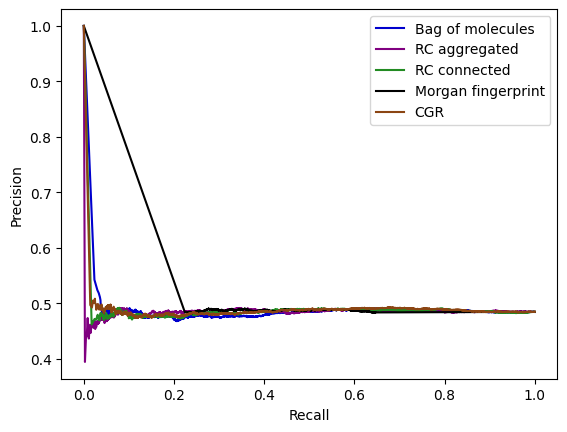

homology


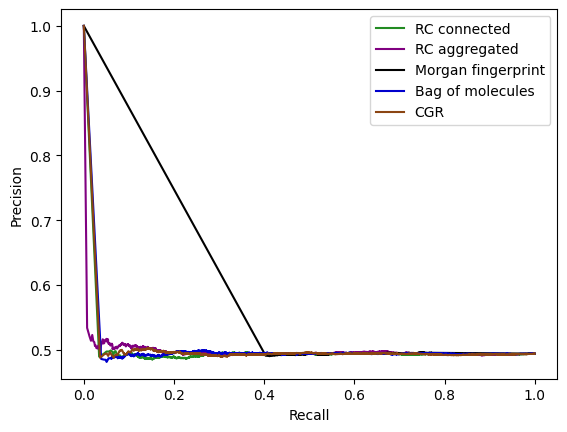

In [32]:
# PRC

for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots()
    for i, row in top_models.loc[top_models['data/split_strategy'] == strat, ['Run ID', 'model/name']].iterrows():
        pred = preds[row["Run ID"]]
        prec, recall, _ = precision_recall_curve(pred['y'], pred['logits'])
        ax.plot(recall, prec, color=colors[row['model/name']], label=labels[row['model/name']])
        
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    plt.savefig(save_to / f"prc_{strat}.svg")
    plt.show()

rcmcs


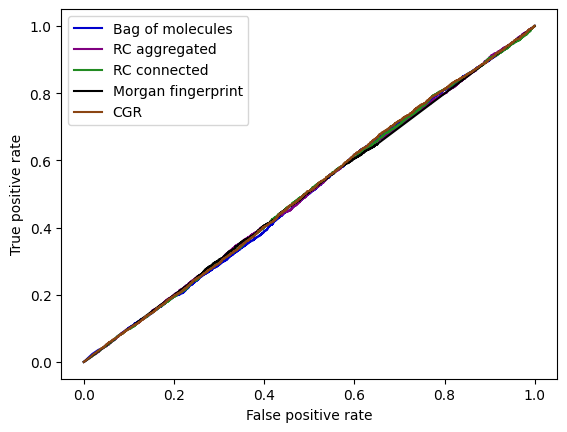

homology


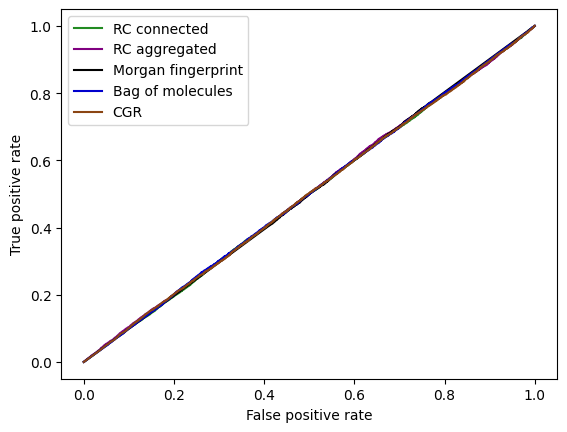

In [33]:
# ROC

for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots()
    for i, row in top_models.loc[top_models['data/split_strategy'] == strat, ['Run ID', 'model/name']].iterrows():
        pred = preds[row["Run ID"]]
        fpr, tpr, _ = roc_curve(pred['y'], pred['logits'])
        ax.plot(fpr, tpr, color=colors[row['model/name']], label=labels[row['model/name']])
        
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.legend()
    plt.savefig(save_to / f"roc_{strat}.svg")
    plt.show()

Top models inner val metrics with test overlay

In [34]:
# Bar chart constants

x = {mn: i for i, mn in enumerate(labels)}
figsize = (10, 3.5)
width = 0.75  # the width of the bars
xtick_rot = 45
xtick_ha = 'right'
ylim = (0.0, 1.0)

rcmcs


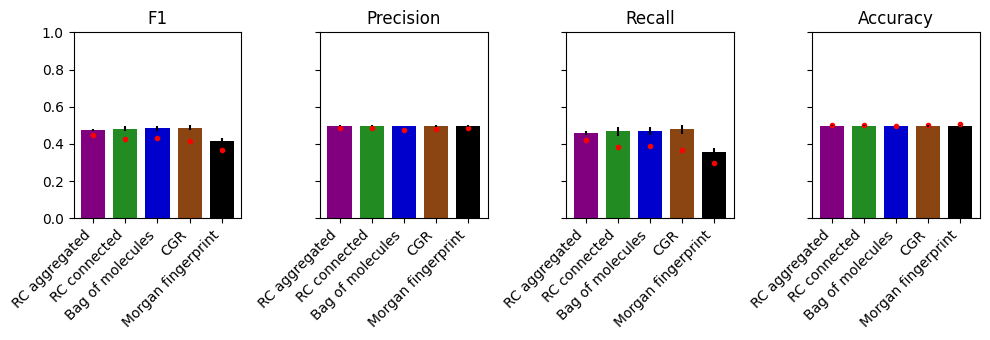

homology


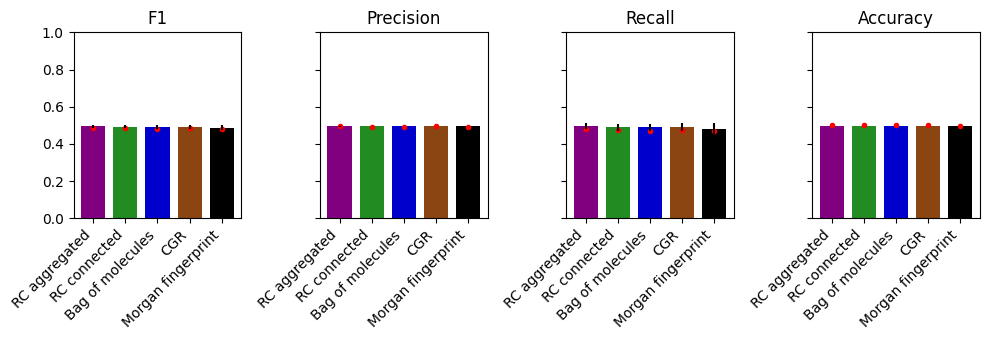

In [35]:
for strat in split_strategies:
    print(strat)
    fig, ax = plt.subplots(ncols=len(metrics), figsize=figsize, sharey=True)
    for j, row in top_models.loc[top_models['data/split_strategy'] == strat].iterrows():
        model_name = row['model/name']
        oid = row['Run ID']
        th = best_thresholds[oid]
        inner_folds = split_runs[oid]
        outer_pred = preds[oid]
        outer_y = outer_pred['y']
        outer_ypred = (outer_pred['logits'] > th).astype(int)
        for i, (metric_k, metric) in enumerate(metrics.items()):
            outer_metric = metric(outer_y, outer_ypred)
            ax[i].plot(x[model_name], outer_metric, 'r.')

            inner_metrics = []
            for iid in inner_folds.loc[:, 'run_id']:
                pred = preds[iid]
                ypred = (pred['logits'] > th).astype(int)
                inner_metrics.append(metric(pred['y'], ypred))
            
            inner_metrics = np.array(inner_metrics)
            ax[i].bar(x=x[model_name], height=inner_metrics.mean(), width=width, yerr=inner_metrics.std(), color=colors[model_name])
            ax[i].set_xticks(list(x.values()))
            ax[i].set_xticklabels(list(labels.values()), rotation=xtick_rot, ha=xtick_ha)
            ax[i].set_title(metric_names[metric_k])
            ax[i].set_ylim(*ylim)

    plt.tight_layout()
    plt.savefig(save_to / f"f1_prec_rec_acc_{strat}.svg")
    plt.show()
            

Performance broken down by similarity bucket

In [36]:
sim_path = Path(filepaths.results) / 'similarity_matrices'
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'

S_rcmcs = load_similarity_matrix(
    sim_path=sim_path,
    dataset=dataset,
    toc=toc,
    sim_metric='rcmcs'
)

S_gsi = load_similarity_matrix(
    sim_path=sim_path,
    dataset=dataset,
    toc=toc,
    sim_metric='gsi'
)

In [37]:
rcmcs_eg = top_models.loc[top_models['data/split_strategy'] == 'rcmcs', 'Run ID'].iloc[0]
gsi_eg = top_models.loc[top_models['data/split_strategy'] == 'homology', 'Run ID'].iloc[0]
val_pidx = preds[gsi_eg].loc[:, 'protein_idx'].to_list()
train_pidx = [i for i in range(S_gsi.shape[0]) if i not in val_pidx]
val_ridx = preds[rcmcs_eg].loc[:, 'reaction_idx'].to_list()
train_ridx = [i for i in range(S_rcmcs.shape[0]) if i not in val_ridx]
max_rcmcs_sims = S_rcmcs[:, val_ridx][train_ridx].max(axis=0)
max_gsi_sims = S_gsi[:, val_pidx][train_pidx].max(axis=0)

for oid in outer_run_ids:
    if len(preds[oid]) == len(max_rcmcs_sims):
        preds[oid]['max_rcmcs'] = max_rcmcs_sims
    elif len(preds[oid]) == len(max_gsi_sims):
        preds[oid]['max_gsi'] = max_gsi_sims

In [38]:
# Clustered bar chart constants

bins = {
    'rcmcs': [
        (0.8, 1),
        (0.6, 0.8),
        (0.4, 0.6),
        (0.0, 0.4),
    ],
    'homology': [
        (0.7, 1),
        (0.4, 0.7),
        (0.3, 0.4),
        (0.0, 0.3),
    ]
}

bins2labels = lambda bins: [f"[{b[0]}, {b[1]})" for b in bins]

bar_shifts = {k: i for i, k in enumerate(labels.keys())}

width = 0.17
space = 1.03
offset = (len(labels) / 2) * width
figsize = (11, 4)
ylim = {
    'rcmcs': (0.0, 1.0),
    'homology': (0.0, 1.0),
} 

rcmcs
val/f1
0.4048582995951417
0.42278978388998034
0.3991752577319587
0.36447307869305107
0.39865149599662875
0.41740674955595025
0.4326210204971653
0.4062072113190324
0.36028659160696014
0.403899721448468
0.3997103548153512
0.42977528089887646
0.4108584005869406
0.3388157894736842
0.3964627855563743
0.4693205627057767
0.49224465905765297
0.4674772036474164
0.3930942895086321
0.44889162561576357


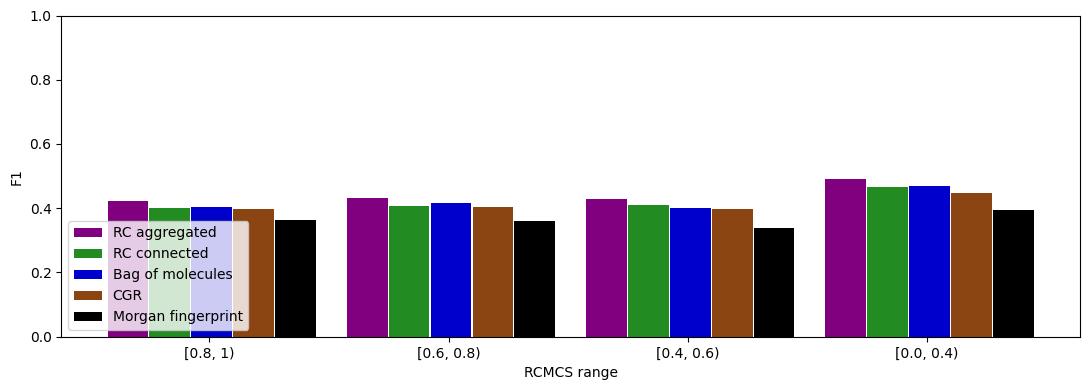

val/binary_precision
0.4187604690117253
0.4239558707643814
0.4212358572671889
0.4414715719063545
0.43117593436645396
0.4359925788497217
0.44325290437890974
0.43756145526057033
0.4512820512820513
0.44387755102040816
0.43125
0.4480234260614934
0.45016077170418006
0.4336842105263158
0.4366883116883117
0.5842026825633383
0.5930888575458392
0.5956622773044152
0.5844027640671273
0.5836669335468375


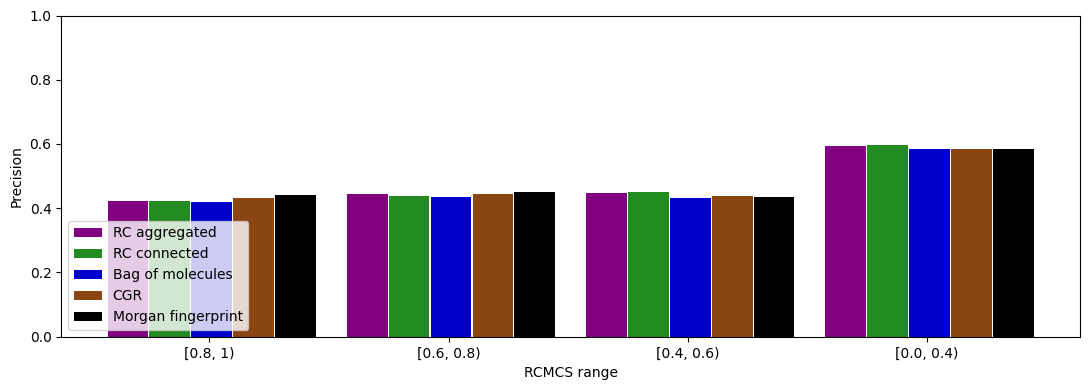

val/binary_recall
0.39184952978056425
0.4216300940438871
0.3793103448275862
0.3103448275862069
0.3706896551724138
0.40034071550255534
0.42248722316865417
0.379045996592845
0.29982964224872233
0.37052810902896083
0.3724696356275304
0.41295546558704455
0.37786774628879893
0.27800269905533065
0.3630229419703104
0.3921960980490245
0.4207103551775888
0.38469234617308656
0.2961480740370185
0.3646823411705853


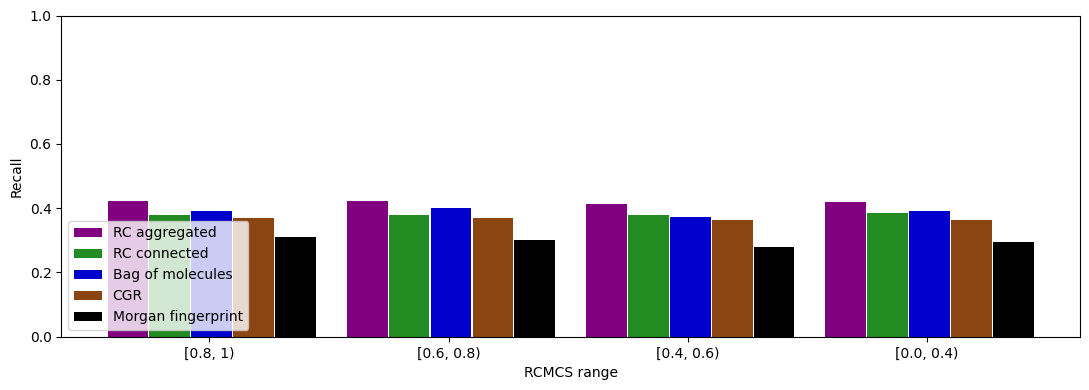

val/accuracy
0.5121141719216727
0.5124460670428145
0.5164288084965151
0.5416528377032858
0.5263856621307667
0.5013302926643861
0.5055112124667427
0.5055112124667427
0.5248954770049411
0.5119726339794755
0.5044829647340108
0.5146443514644351
0.5200239091452481
0.5194261805140467
0.5104602510460251
0.47745358090185674
0.4886531093427645
0.48364279398762156
0.4612437371058061
0.47244326554671384


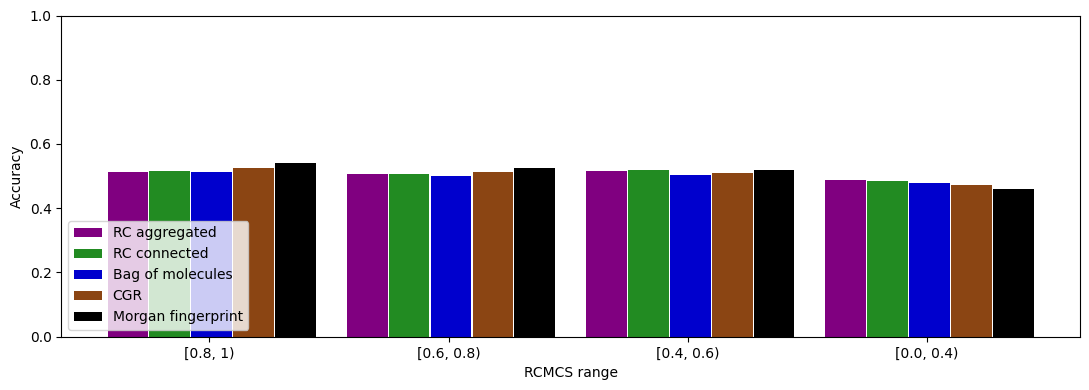

homology
val/f1
0.49538679914833217
0.5008830801836807
0.49338577046835896
0.48927038626609437
0.49679715302491106
0.48273244781783686
0.4820822331195775
0.47528517110266155
0.4708126669210225
0.47723823975720786
0.4556341076323763
0.4549504239114815
0.45044260629807
0.4538595473012188
0.4564746643568644
0.49607535321821045
0.5023376623376624
0.4919863373620599
0.4956749672346003
0.4978411618474421


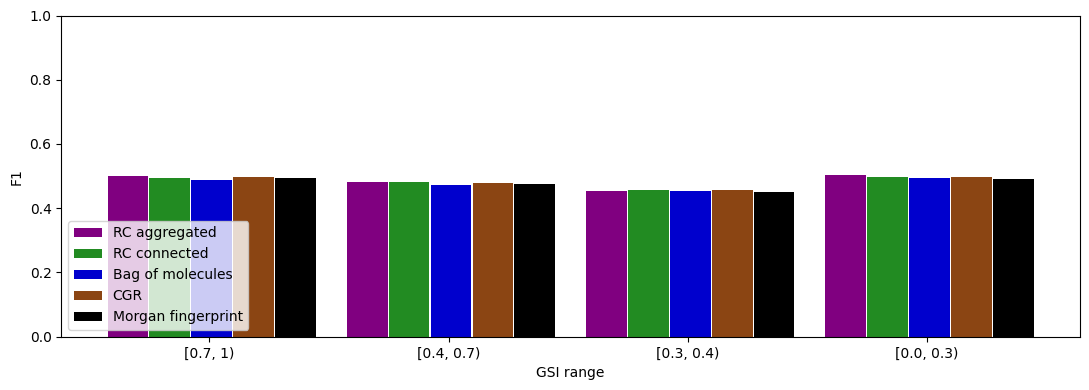

val/binary_precision
0.5328244274809161
0.5359032501889645
0.5352986811481769
0.531055900621118
0.5360983102918587
0.49074074074074076
0.4870426829268293
0.48412083656080557
0.48127925117004683
0.48496530454895914
0.435946990612921
0.4336986301369863
0.4332774986041318
0.43650572146246164
0.4369817578772803
0.5160587915078934
0.5184986595174262
0.5141405820977485
0.5166666666666667
0.5179689627007895


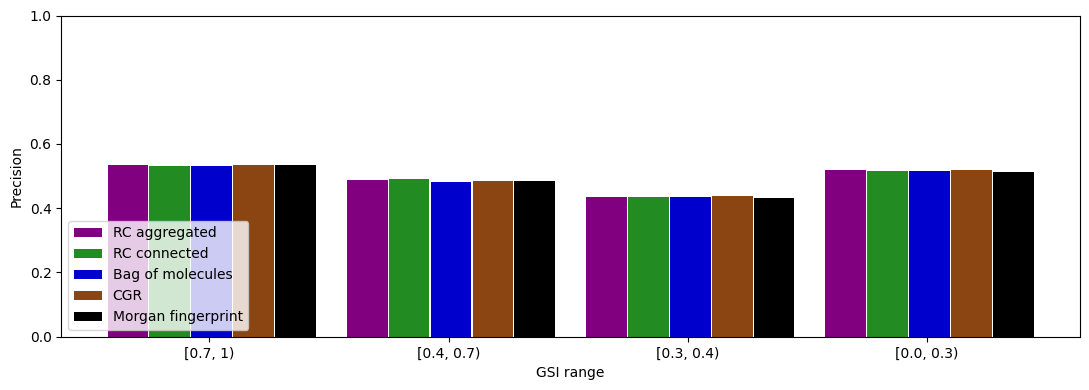

val/binary_recall
0.46286472148541113
0.47015915119363394
0.45755968169761274
0.4535809018567639
0.46286472148541113
0.4749813293502614
0.4772218073188947
0.46676624346527257
0.4607916355489171
0.4697535474234503
0.47718343910546995
0.47839226352372316
0.4690238742822605
0.47265034753702023
0.47778785131459656
0.47758186397984886
0.4871536523929471
0.4716624685138539
0.47632241813602016
0.4792191435768262


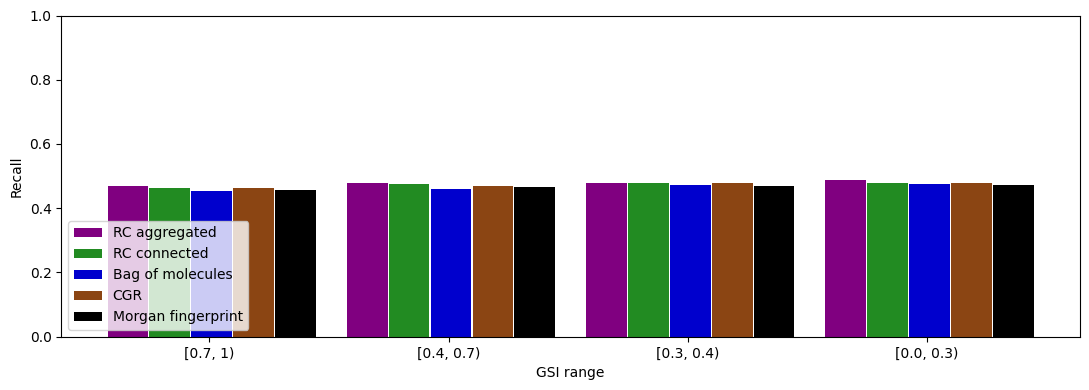

val/accuracy
0.4890406036651096
0.49227452389507725
0.4908372260150916
0.48688465684513116
0.49191519942508083
0.5034608378870674
0.49981785063752276
0.4972677595628415
0.4947176684881603
0.49799635701275047
0.5025052742616034
0.4998681434599156
0.5006592827004219
0.5036919831223629
0.5035601265822784
0.5002594706798131
0.502854177477945
0.4983134405812143
0.5007784120394395
0.5020757654385054


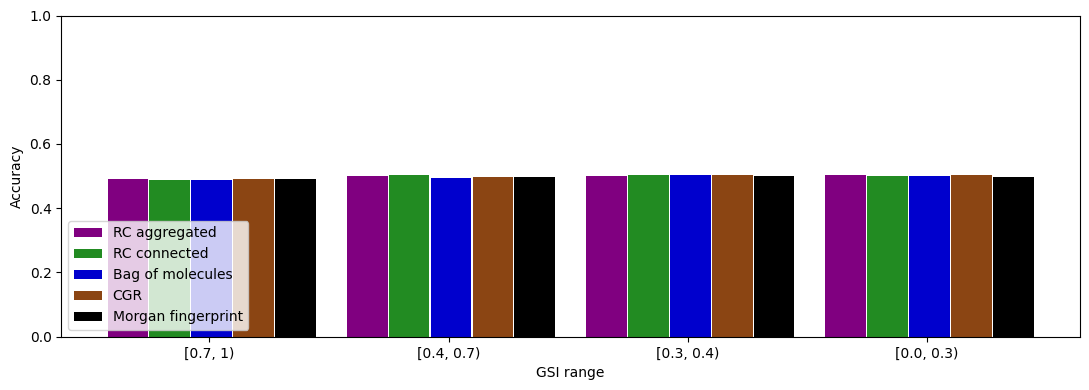

In [39]:
for strat in split_strategies:
    print(strat)
    x = [i for i in range(len(bins[strat]))]
    for metric_k, metric in metrics.items():
        print(metric_k)
        fig, ax = plt.subplots(figsize=figsize, sharey=True)
        for i, (lb, ub) in enumerate(bins[strat]):
            for _, row in top_models.loc[top_models['data/split_strategy'] == strat].iterrows():
                model_name = row['model/name']
                oid = row['Run ID']
                th = best_thresholds[oid]
                pred = preds[oid]

                if strat == 'rcmcs':
                    pred = pred.loc[(pred['max_rcmcs'] < ub) & (pred['max_rcmcs'] >= lb)]
                elif strat == 'homology':
                    pred = pred.loc[(pred['max_gsi'] < ub) & (pred['max_gsi'] >= lb)]
                
                ypred = (pred['logits'] > th).astype(int)
                metric_val = metric(pred['y'], ypred)

                ax.bar(x=x[i] - offset + width * bar_shifts[model_name] * space, height=metric_val, width=width, color=colors[model_name])
                print(metric_val)
            
        for key in labels:
            ax.bar(0, 0, color=colors[key], label=labels[key])
        
        ax.set_ylim(*ylim[strat])
        ax.set_xticks(np.array(x) - width / 2)
        ax.set_xticklabels(bins2labels(bins[strat]))
        ax.set_ylabel(metric_names[metric_k])
        ax.set_xlabel(f"{similarity_names[strat]} range")
        ax.legend(loc='lower left')
        plt.tight_layout()
        plt.savefig(save_to / f"{strat}_similarity_clustered_{metric_names[metric_k]}.svg")
        plt.show()

In [40]:
# Split count bar constants

width = 0.5

x = [i for i in range(len(bins[strat]))]
figsize = (6, 4)
ylim = (0.0, 1.0)

rcmcs


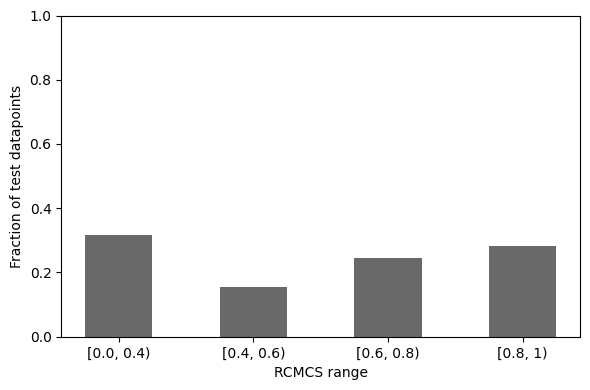

homology


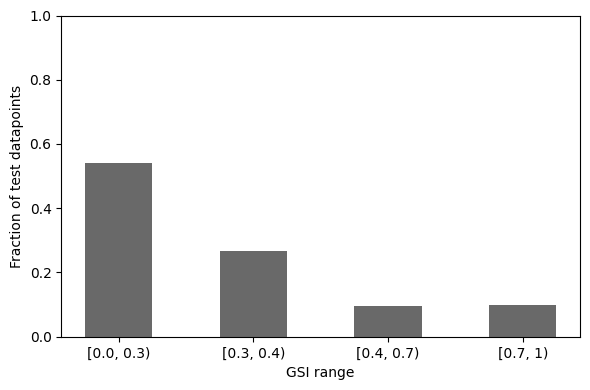

In [41]:
# Background split counts

for strat, eg_id in zip(split_strategies, [rcmcs_eg, gsi_eg]):
    print(strat)
    fig, ax = plt.subplots(figsize=figsize, sharey=True)
    for i, (lb, ub) in enumerate(bins[strat][::-1]):
        pred = preds[eg_id]
        n_tot = len(pred)

        if strat == 'rcmcs':
            n_bucket = len(pred.loc[(pred['max_rcmcs'] < ub) & (pred['max_rcmcs'] >= lb)])
        elif strat == 'homology':
            n_bucket = len(pred.loc[(pred['max_gsi'] < ub) & (pred['max_gsi'] >= lb)])

        ax.bar(x=x[i], height=n_bucket / n_tot, width=width, color="dimgray")
    
    ax.set_ylim(*ylim)
    ax.set_xticks(x)
    ax.set_xticklabels(bins2labels(bins[strat])[::-1])
    ax.set_ylabel("Fraction of test datapoints")
    ax.set_xlabel(f"{similarity_names[strat]} range")
    plt.tight_layout()
    plt.savefig(save_to / f"{strat}_similarity_split_counts.svg")
    plt.show()

In [42]:
# Background hist constants

nbins = 20
figsize = (6, 4)

rcmcs


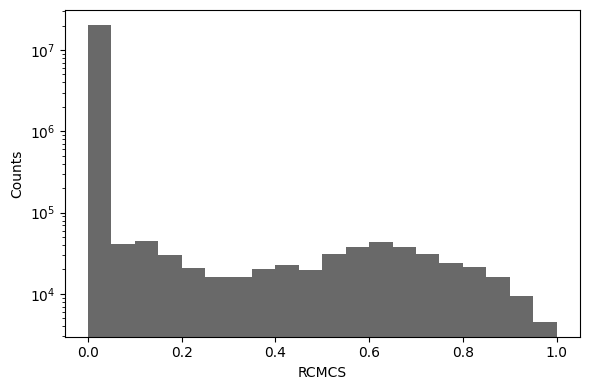

homology


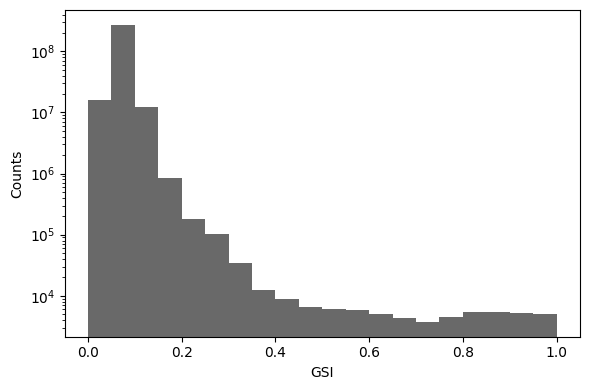

In [43]:
# Background max sim distribution

for strat, eg_id in zip(split_strategies, [rcmcs_eg, gsi_eg]):
    print(strat)
    fig, ax = plt.subplots(figsize=figsize, sharey=True)
    pred = preds[eg_id]

    if strat == 'rcmcs':
        sims = S_rcmcs[np.triu_indices_from(S_rcmcs, k=1)]
        # sims = pred['max_rcmcs'].to_list()
    elif strat == 'homology':
        sims = S_gsi[np.triu_indices_from(S_gsi, k=1)]
        # sims = pred["max_gsi"].to_list()

    ax.hist(sims, bins=nbins, color="dimgray")
    ax.set_ylabel("Counts")
    ax.set_yscale('log')
    ax.set_xlabel(f"{similarity_names[strat]}")
    plt.tight_layout()
    plt.savefig(save_to / f"{strat}_similarity_hist.svg")
    plt.show()

Performance as a function of number of message passings

In [44]:
# Bar chart constants

x = message_passing_sweep['params.model/encoder_depth'].unique().astype(int)
x.sort()
xticks = x.astype(str)

colors = {
    "rc_agg": "purple",
    "bom": "mediumblue",
}

def get_shades(color, n_shades=6):
    base_color = mcolors.to_rgba(color)
    return [(base_color[0], base_color[1], base_color[2], base_color[3] * (i / n_shades)) for i in range(1, n_shades + 1)]

shaded_colors = {key: get_shades(value) for key, value in colors.items()}
print(shaded_colors)

figsize = (5, 3)
width = 0.8  # the width of the bars
ylim = (0.5, 1.0)

{'rc_agg': [(0.5019607843137255, 0.0, 0.5019607843137255, 0.16666666666666666), (0.5019607843137255, 0.0, 0.5019607843137255, 0.3333333333333333), (0.5019607843137255, 0.0, 0.5019607843137255, 0.5), (0.5019607843137255, 0.0, 0.5019607843137255, 0.6666666666666666), (0.5019607843137255, 0.0, 0.5019607843137255, 0.8333333333333334), (0.5019607843137255, 0.0, 0.5019607843137255, 1.0)], 'bom': [(0.0, 0.0, 0.803921568627451, 0.16666666666666666), (0.0, 0.0, 0.803921568627451, 0.3333333333333333), (0.0, 0.0, 0.803921568627451, 0.5), (0.0, 0.0, 0.803921568627451, 0.6666666666666666), (0.0, 0.0, 0.803921568627451, 0.8333333333333334), (0.0, 0.0, 0.803921568627451, 1.0)]}


rcmcs
bom
val/f1


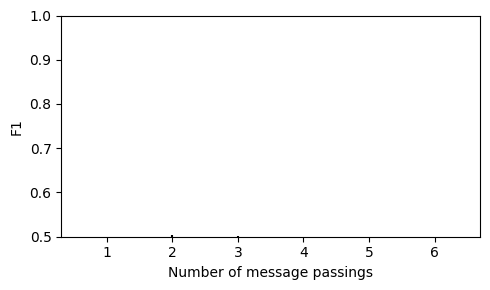

val/binary_precision


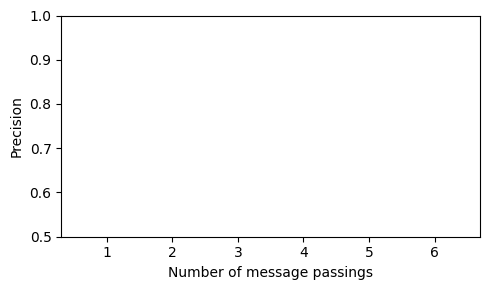

val/binary_recall


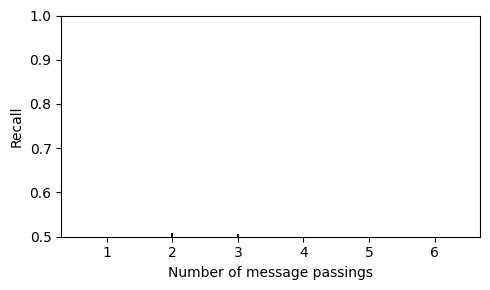

val/accuracy


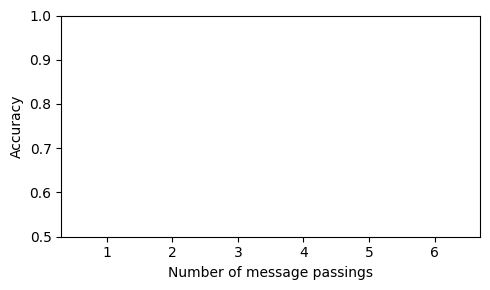

rc_agg
val/f1


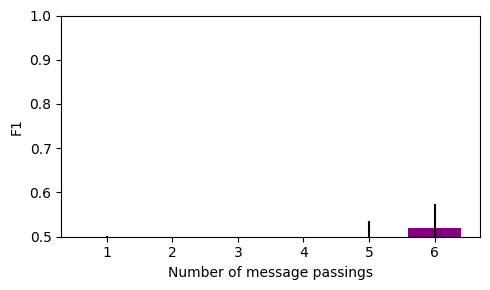

val/binary_precision


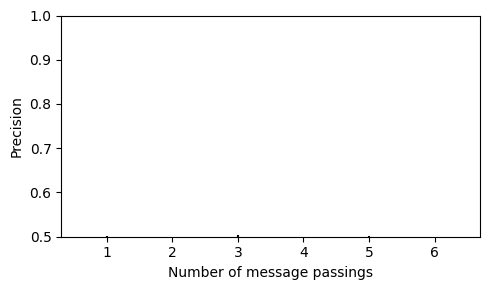

val/binary_recall


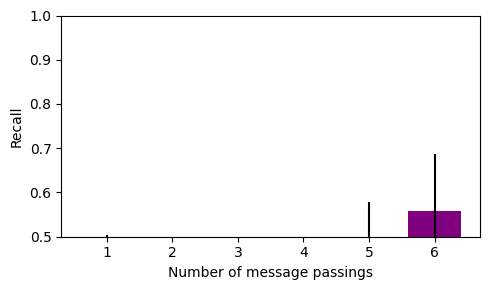

val/accuracy


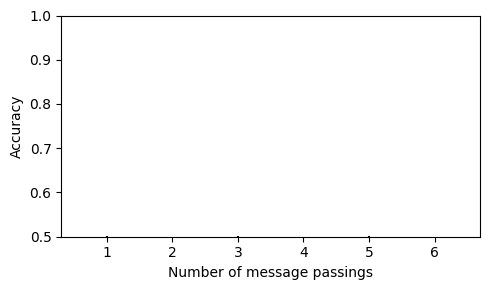

homology
bom
val/f1


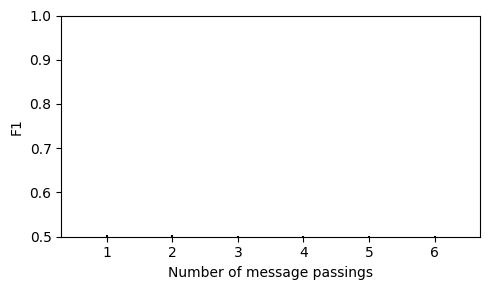

val/binary_precision


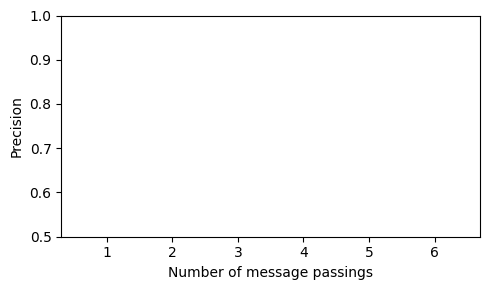

val/binary_recall


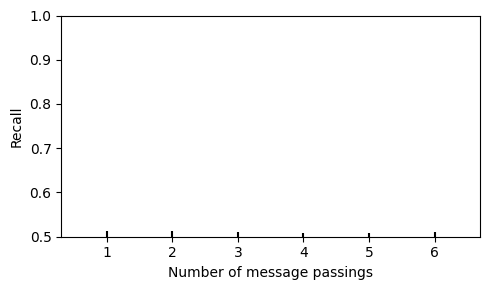

val/accuracy


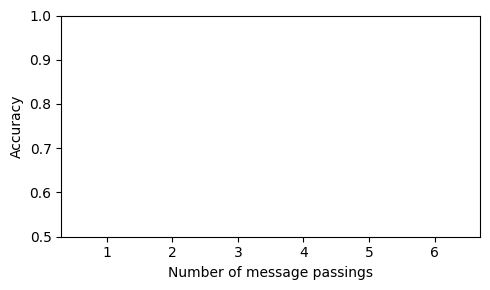

rc_agg
val/f1


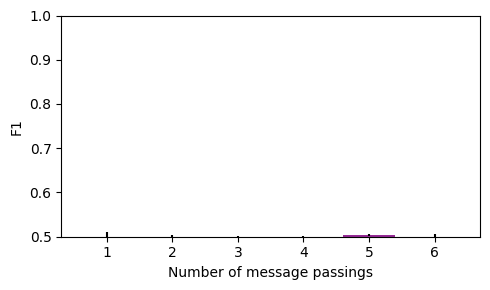

val/binary_precision


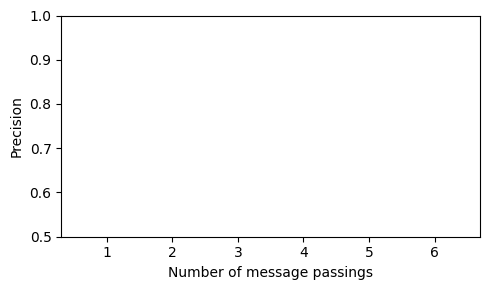

val/binary_recall


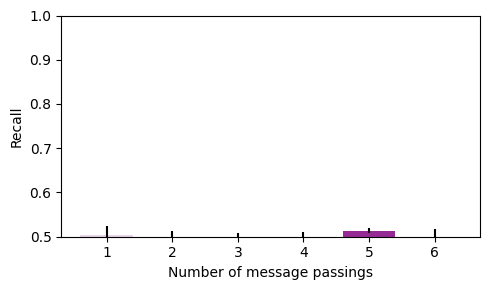

val/accuracy


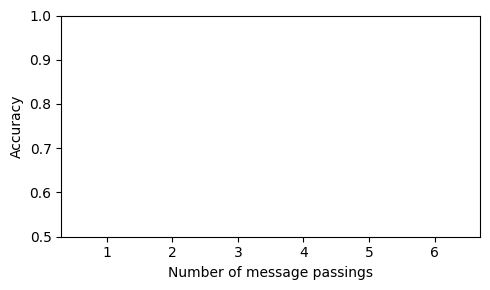

In [45]:
for strat in split_strategies:
    print(strat)
    for model_name in message_passing_sweep['params.model/name'].unique():
        print(model_name)
        for metric_k, metric in metrics.items():
            print(metric_k)
            fig, ax = plt.subplots(figsize=figsize, sharey=True)
            sel = (message_passing_sweep['params.model/name'] == model_name) & (message_passing_sweep['params.data/split_strategy'] == strat)
            for i, row in message_passing_sweep.loc[sel].iterrows():
                oid = row['run_id']
                n_mp = int(row['params.model/encoder_depth'])
                
                th = best_thresholds[oid]
                inner_folds = split_runs[oid]
                inner_metrics = []
                for iid in inner_folds.loc[:, 'run_id']:
                    pred = preds[iid]
                    ypred = (pred['logits'] > th).astype(int)
                    inner_metrics.append(metric(pred['y'], ypred))
            
                inner_metrics = np.array(inner_metrics)
                ax.bar(x=n_mp, height=inner_metrics.mean(), width=width, yerr=inner_metrics.std(), color=shaded_colors[model_name][n_mp - 1])

            ax.set_ylim(*ylim)
            ax.set_xlabel("Number of message passings")
            ax.set_ylabel(metric_names[metric_k])
            plt.tight_layout()
            plt.savefig(save_to / f"{model_name}_{strat}_{metric_names[metric_k]}_v_message_passings.svg")
            plt.show()
            